<a href="https://colab.research.google.com/github/adalbertii/modele-NLP/blob/main/NLP_english_spanish_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-nlp --upgrade
!pip install rouge-score # zestaw wskaźników i pakiet oprogramowania używany do oceny modeli
                         # do automatycznego podsumowania i tłumaczenia maszynowego w przetwarzaniu języka naturalnego

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 39.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=96dd41ad67fd835f846b7a56ae064c0124bf085e30b1ecc356ac2d3d7c617320
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [2]:
import keras_nlp
#---------------------------------------
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import pathlib
import random
import string
import re
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import sklearn
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

Using TensorFlow backend


In [6]:
class Config:
    vocab_size = 15000 # rozmiar słownika
    sequence_length = 20
    batch_size = 512
    validation_split = 0.15
    embed_dim = 256
    latent_dim = 256
    num_heads = 2
    epochs = 30 # liczba epko w procesie trenowania
    start_token = "[start]"
    end_token = "[end]"

config = Config()

In [7]:
data = pd.read_csv("/content/drive/MyDrive/dane/data-english-spanish.csv")
data.head()

,english,spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


In [ ]:
data[100:110]

,english,spanish
100,Go away!,¡Salga de aquí!
101,Go away!,¡Largo!
102,Go away!,¡Vete ya!
103,Go away!,¡Órale!
104,Go away!,¡A la calle!
105,Go away.,¡Vete de aquí!
106,Go away.,¡Lárgate!
107,Go away.,¡Largo!
108,Go away.,¡Vete ya!
109,Go away.,¡Órale!


In [8]:
data["spanish"] = data["spanish"].apply(lambda item: f"{config.start_token} " + item + f" {config.end_token}")

In [ ]:
data["spanish"][100:110]

100    [start] [start] ¡Salga de aquí! [end] [end]
101            [start] [start] ¡Largo! [end] [end]
102          [start] [start] ¡Vete ya! [end] [end]
103            [start] [start] ¡Órale! [end] [end]
104       [start] [start] ¡A la calle! [end] [end]
105     [start] [start] ¡Vete de aquí! [end] [end]
106          [start] [start] ¡Lárgate! [end] [end]
107            [start] [start] ¡Largo! [end] [end]
108          [start] [start] ¡Vete ya! [end] [end]
109            [start] [start] ¡Órale! [end] [end]
Name: spanish, dtype: object

In [ ]:
data.head()

,english,spanish
0,Go.,[start] [start] Ve. [end] [end]
1,Go.,[start] [start] Vete. [end] [end]
2,Go.,[start] [start] Vaya. [end] [end]
3,Go.,[start] [start] Váyase. [end] [end]
4,Hi.,[start] [start] Hola. [end] [end]


In [ ]:
data.shape

(118964, 2)

In [9]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
print(strip_chars)

!"#$%&'()*+,-./:;<=>?@\^_`{|}~¿


In [10]:
def spanish_standardize(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]"%re.escape(strip_chars), "")

In [11]:
english_vectorization = TextVectorization(
    max_tokens=config.vocab_size,
    output_mode="int",
    output_sequence_length=config.sequence_length,
)

In [12]:
spanish_vectorization = TextVectorization(
    max_tokens=config.vocab_size,
    output_mode="int",
    output_sequence_length=config.sequence_length + 1,
    standardize=spanish_standardize,
)

In [13]:
english_vectorization.adapt(list(data["english"]))

In [14]:
spanish_vectorization.adapt(list(data["spanish"]))

In [15]:
def preprocess(english, spanish):
    english = english_vectorization(english)
    spanish = spanish_vectorization(spanish)
    return ({"encoder_inputs": english, "decoder_inputs": spanish[:, :-1]}, spanish[:, 1:])


In [16]:
def make_dataset(df, batch_size, mode):
    dataset = tf.data.Dataset.from_tensor_slices((list(df["english"]), list(df["spanish"])))
    if mode == "train":
       dataset = dataset.shuffle(batch_size * 4)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(preprocess)
    dataset = dataset.prefetch(tf.data.AUTOTUNE).cache()
    return dataset

In [17]:
train, valid = train_test_split(data, test_size=config.validation_split)
train.shape, valid.shape

((101119, 2), (17845, 2))

In [18]:
train_ds = make_dataset(train, batch_size=config.batch_size, mode="train")
valid_ds = make_dataset(valid, batch_size=config.batch_size, mode="valid")

In [ ]:
type(train_ds)

tensorflow.python.data.ops.cache_op.CacheDataset

In [ ]:
for batch in train_ds.take(1):
    print(batch)

({'encoder_inputs': <tf.Tensor: shape=(512, 20), dtype=int64, numpy=
array([[  21,    8, 2718, ...,    0,    0,    0],
       [   9,   44,  794, ...,    0,    0,    0],
       [  49, 5145,    0, ...,    0,    0,    0],
       ...,
       [5971,    8,   33, ...,    0,    0,    0],
       [   3,   22,  235, ...,    0,    0,    0],
       [   3,   14,  583, ...,    0,    0,    0]])>, 'decoder_inputs': <tf.Tensor: shape=(512, 20), dtype=int64, numpy=
array([[   2,    2,   89, ...,    0,    0,    0],
       [   2,    2,   20, ...,    0,    0,    0],
       [   2,    2,  435, ...,    0,    0,    0],
       ...,
       [   2,    2, 8891, ...,    0,    0,    0],
       [   2,    2,    7, ...,    0,    0,    0],
       [   2,    2,  384, ...,    0,    0,    0]])>}, <tf.Tensor: shape=(512, 20), dtype=int64, numpy=
array([[   2,   89,   22, ...,    0,    0,    0],
       [   2,   20, 1353, ...,    0,    0,    0],
       [   2,  435, 8450, ...,    0,    0,    0],
       ...,
       [   2, 8891,   

**Etap budowy modelu Transformera**

In [ ]:
def get_model(config):
    encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
    x = keras_nlp.layers.TokenAndPositionEmbedding(
        config.vocab_size,
        config.sequence_length,
        config.embed_dim,
        mask_zero=True
    )(encoder_inputs)
    encoder_outputs = keras_nlp.layers.TransformerEncoder(intermediate_dim=config.embed_dim, num_heads=config.num_heads)(x)
    encoder = keras.Model(encoder_inputs, encoder_outputs)

    decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
    encoded_seq_inputs = keras.Input(shape=(None, config.embed_dim), name="decoder_state_inputs")
    x = keras_nlp.layers.TokenAndPositionEmbedding(
        config.vocab_size,
        config.sequence_length,
        config.embed_dim,
        mask_zero=True
    )(decoder_inputs)
    x = keras_nlp.layers.TransformerDecoder(config.latent_dim, config.num_heads)(x, encoded_seq_inputs)
    x = layers.Dropout(0.1)(x)
    decoder_outputs = layers.Dense(config.vocab_size, activation="softmax")(x)
    decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

    decoder_outputs = decoder([decoder_inputs, encoder_outputs])
    transformer = keras.Model(
        [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
    )
    transformer.compile(
        "adam",
        loss="sparse_categorical_crossentropy",
        metrics=[
            "accuracy"
        ]
    )
    return transformer

In [ ]:
model = get_model(config)

In [ ]:
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 token_and_position_embeddi  (None, None, 256)            3845120   ['encoder_inputs[0][0]']      
 ng (TokenAndPositionEmbedd                                                                       
 ing)                                                                                             
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                  

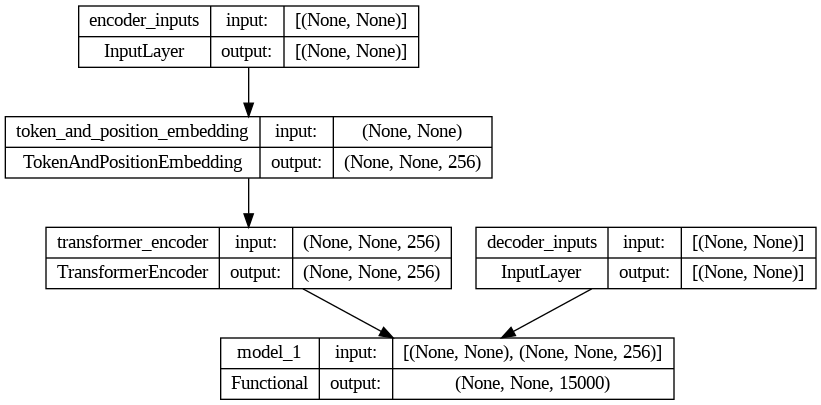

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

**Etap trenowania modelu**

In [ ]:
checkpoints = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/dane/modele/model.tf",
    monitor="val_accuracy",
    mode="min",
    save_best_only=True
)


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=10,
    monitor="val_loss",
    mode="min",
    restore_best_weights=True
)

In [ ]:
history = model.fit(train_ds, epochs=config.epochs, validation_data=valid_ds, callbacks=[checkpoints, early_stop])
# proces uczenia zajmuje około 4 minut przy aktywnym V100 GPU

Epoch 1/30
198/198 [==============================] - 52s 198ms/step - loss: 4.0878 - accuracy: 0.4073 - val_loss: 2.5871 - val_accuracy: 0.5747
Epoch 2/30
198/198 [==============================] - 14s 72ms/step - loss: 2.0034 - accuracy: 0.6500 - val_loss: 1.8059 - val_accuracy: 0.6786
Epoch 3/30
198/198 [==============================] - 14s 71ms/step - loss: 1.3619 - accuracy: 0.7295 - val_loss: 1.6097 - val_accuracy: 0.6954
Epoch 4/30
198/198 [==============================] - 14s 71ms/step - loss: 1.0476 - accuracy: 0.7706 - val_loss: 1.4900 - val_accuracy: 0.7145
Epoch 5/30
198/198 [==============================] - 14s 71ms/step - loss: 0.8537 - accuracy: 0.8000 - val_loss: 1.4707 - val_accuracy: 0.7175
Epoch 6/30
198/198 [==============================] - 14s 70ms/step - loss: 0.7302 - accuracy: 0.8213 - val_loss: 1.4733 - val_accuracy: 0.7208
Epoch 7/30
198/198 [==============================] - 14s 70ms/step - loss: 0.6428 - accuracy: 0.8374 - val_loss: 1.4979 - val_accuracy

**Załadowanie wytrenowanego wcześniej modelu**

In [4]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/dane/modele/model.tf", custom_objects={
    "TokenAndPositionEmbedding": keras_nlp.layers.TokenAndPositionEmbedding,
    "TransformerEncoder": keras_nlp.layers.TransformerEncoder,
    "TransformerDecoder": keras_nlp.layers.TransformerDecoder
})
loaded_model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 token_and_position_embeddi  (None, None, 256)            3845120   ['encoder_inputs[0][0]']      
 ng (TokenAndPositionEmbedd                                                                       
 ing)                                                                                             
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                  

Tłumaczenie tekstów w oparciu o załądowany model **NLP**

In [19]:
spanish_vocab = spanish_vectorization.get_vocabulary()
spanish_index_lookup = dict(zip(range(len(spanish_vocab)), spanish_vocab))
start_index = spanish_vocab.index(config.start_token)
end_index = spanish_vocab.index(config.end_token)
unk_index = spanish_vocab.index("[UNK]")
def decode_sequence(model, input_sentence, filtered_values = [start_index, end_index, unk_index]):
    tokenized_input_sentence = english_vectorization([input_sentence])
    decoded_sentence = [start_index] + [0] * (config.sequence_length)
    for i in range(config.sequence_length):
        decoded_sentence_constant = tf.constant([decoded_sentence[:config.sequence_length]])
        predictions = model([tokenized_input_sentence, decoded_sentence_constant])
        sampled_token_index = np.argmax(predictions[0, i, :])
        decoded_sentence[i + 1] = sampled_token_index
        if sampled_token_index == end_index:
            break
    components = [spanish_index_lookup[c] for c in decoded_sentence if c not in filtered_values]
    return " ".join(components)

In [20]:
# Wybierzmy losowe teksty, przetłumaczmy je z angielskiego na hiszpański przy użyciu tego modelu
# i porównajmy z rzeczywistym wynikiem.
for i in tqdm(np.random.choice(len(data), 10)):
    item = data.iloc[i]
    translated = decode_sequence(loaded_model, item["english"])
    print("English:", item["english"])
    print("Spanish:", item["spanish"].replace("[start] ", "").replace(" [end]", ""))
    print("Translated:", translated)

  0%|          | 0/10 [00:00<?, ?it/s]

English: Would you tell me when to get off?
Spanish: ¿Me dirás cuando tengo que marcharme?
Translated: me gustaría que me              
English: Chinese is not too difficult to learn.
Spanish: El chino no es muy difícil de aprender.
Translated: el agua no es demasiado difícil de aprender           
English: Tom abandoned the hope of becoming an actor.
Spanish: Tom abandonó la esperanza de convertirse en un actor.
Translated: tom la esperanza de             
English: He can't stay long.
Spanish: No puede quedarse por mucho tiempo.
Translated: Él no puede ser más de nuevo            
English: Her name often escapes me.
Spanish: Su nombre a menudo se me escapa.
Translated: su nombre me               
English: My son doesn't obey me.
Spanish: Mi hijo no me obedece.
Translated: mi hijo no me no me             
English: Tom has a map.
Spanish: Tom tiene un mapa.
Translated: tom tiene un banco               
English: Don't tell me off like that.
Spanish: No me riñas de esa forma.
Translated: 

**Ewaluacja modelu za pomocą EditDistance, RougeL**

**EditDistance** to najmniejsza liczba operacji wymaganych do konwersji jednego ciągu na inny, przy czym operacją może być podstawienie, usunięcie lub wstawienie. Domyślnie ta metryka obliczy znormalizowany wynik.

**ROUGE** oznacza Recall-Oriented Understudy for Gisting Evaluation. Zawiera środki umożliwiające automatyczne określenie jakości podsumowania poprzez porównanie go z innymi (idealnymi) podsumowaniami stworzonymi przez ludzi.
Miary zliczają liczbę nakładających się jednostek, takich jak n-gramy, sekwencje słów i pary słów, pomiędzy podsumowaniem wygenerowanym komputerowo, które ma zostać poddane ocenie, a idealnymi podsumowaniami stworzonymi przez ludzi.

**Metryka ROUGE-L** jest tradycyjnie używana do oceny systemów podsumowujących. Krótko mówiąc, ROUGE-L to wynik oparty na długości najdłuższego wspólnego podciągu występującego w tekście odniesienia i tekście hipotezy.

Model może przetłumaczyć 4 zdania na sekundę.
Tłumaczenie całego zestawu walidacyjnego zawierającego 17 000 próbek zajmie ponad godzinę.

Ocena zostanie dokonana na podstawie 1000 próbek

In [21]:
eval_size = 1000
y_true = [sentence.replace("[start] ", "").replace(" [end]", "") for sentence in valid["spanish"][:eval_size]]
y_pred = []
for i in tqdm(range(eval_size)):
    item = valid.iloc[i]
    translated = decode_sequence(loaded_model, item["english"]).strip()
    y_pred.append(translated)

  0%|          | 0/1000 [00:00<?, ?it/s]

**Metryka "Edit Distance"**

In [22]:
y_true_vector = spanish_vectorization(y_true)
y_pred_vector = spanish_vectorization(y_pred)
y_true_vector.shape, y_pred_vector.shape


(TensorShape([1000, 21]), TensorShape([1000, 21]))

In [23]:
y_true_flatten_vector = tf.reshape(y_true_vector, (-1))
y_pred_flatten_vector = tf.reshape(y_pred_vector, (-1))

**Metryka RougeL**

In [24]:
routeL = keras_nlp.metrics.RougeL()
routeL(y_true, y_pred)

{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.49492604>,
 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.43334508>,
 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.45092884>}